# Super-resolution on semi-algebraic domains

In [1]:
using DynamicPolynomials
using MultivariateMoments
using SemialgebraicSets

using Plots
using Plots.PlotMeasures
using PyPlot

using Random
using Distributions  

const MM = MultivariateMoments

include("../src/BeurlingLasso.jl")
using .BeurlingLasso

Random.seed!(0);

┌ Info: Recompiling stale cache file /home/rom1/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/rom1/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/rom1/.julia/compiled/v1.1/Distributions/xILW0.ji for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/rom1/.julia/compiled/v1.1/SumOfSquares/VZKsW.ji for SumOfSquares [4b9e565b-77fc-50a5-a571-1244f986bda1]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/rom1/.julia/compiled/v1.1/Optim/R5uoh.ji for Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/rom1/.julia/compiled/v1.1/GLMNet/2sTil.ji for GLMNet [8d5ece8b-de18-5317-b113-243142960cc6]
└ @ Base loading.jl:1184


In [2]:
pyplot()
PyPlot.matplotlib.rc("text", usetex=true)
PyPlot.matplotlib.rc("font", family="serif")
Plots.scalefontsizes(1.5)

In [3]:
function example(x, locations, amplitudes, domain, d, ϵ, σ=0, λ=0)
    μ0 = AtomicMeasure(x, [WeightedDiracMeasure(locations[i], amplitudes[i]) 
                           for i=1:length(locations)])
    
    monos = monomials(x, 0:d)
    φ = [polynomial(mono) for mono in monos]
    m = length(φ)
    
    y = [MM.expectation(μ0, φ[i]) for i=1:m]
    noisy_y = y + rand(Normal(0, σ * sqrt(mean(y.^2))), m)
    
    prob = blasso(y, φ, λ, domain)
    solver = momsossolver(ϵ)

    solve!(prob, solver)
    
    dualcertif_poly = sum(prob.dualsol[i] * φ[i] for i=1:m)
    dualcertif(u) = dualcertif_poly(x=>u)
    
    return prob.objvalue, prob.μ, dualcertif
end;

## Noiseless setting

### 1D example

Trying to recover $\mu=\delta_{-\frac{3}{4}}+\delta_{\frac{1}{2}}-\delta_{\frac{1}{8}}$

In [4]:
locations = [[-3/4], [1/2], [1/8]]
amplitudes = [1, 1, -1]

@polyvar x[1:1]
domain = @set - (x[1] + 1) * (x[1] + 1/2) * x[1] * (x[1] - 1) >= 0

d = 10
ϵ = 1e-3;

In [5]:
objvalue, μ, dualcertif = example(x, locations, amplitudes, domain, d, ϵ);

In [6]:
println("Objective value : ")
println(objvalue)

Objective value : 
2.999999762939666


The objective value is almost equal to $||\mu||_{\text{TV}}$

In [7]:
println("Optimal measure : ")
show(μ)

Optimal measure : 
Atomic measure on the variables x[1] with 3 atoms:
 at [-0.75] with weight 1.0000002363764744
 at [0.5] with weight 0.9999996295689589
 at [0.125] with weight -0.9999998629302419

$\mu$ is recovered with good precison

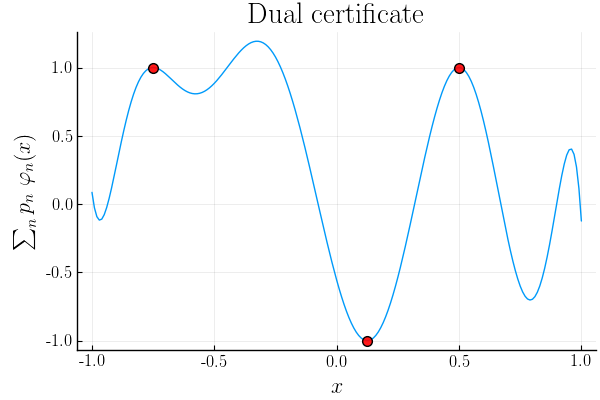

In [8]:
x_tab = -1:0.01:1
y_tab = [dualcertif([x_tab[i]]) for i=1:length(x_tab)]

Plots.plot(x_tab, y_tab, legend=false, left_margin=5mm)
plot!(title="Dual certificate", xlabel=L"$x$", ylabel=L"$\sum_n p_n~\varphi_n(x)$")

scatter!([atom.center for atom in μ.atoms], [sign(atom.weight) for atom in μ.atoms]', 
         markersize = 7, markeralpha = 0.9, markercolor = :red, legend=false)

The figure above shows the dual certificate $\sum_n p_n~\varphi_n(x)$

### 2D example

In [9]:
locations = [[-1/2, 1/2], [1/2, -1/2], [1/2, 1/2], [0, 0], [0, -1/2], [1/2, 0]]
amplitudes = [1 1 1 1 -1 -1]

@polyvar x[1:2]
domain = @set 1 - x[1]^2 >= 0 && 1 - x[2]^2 >= 0

d = 12
ϵ = 1e-3;

In [10]:
objvalue, μ, dualcertif = example(x, locations, amplitudes, domain, d, ϵ);

In [11]:
println("Objective value : ", objvalue)

Objective value : 5.999992208232079


The objective value is almost equal to $||\mu||_{\text{TV}}$

In [12]:
println("Optimal measure : ")
show(μ)

Optimal measure : 
Atomic measure on the variables x[1], x[2] with 6 atoms:
 at [0.499995, 0.499999] with weight 1.000028736911265
 at [-0.49996, 0.499952] with weight 1.0001535672678823
 at [0.49999, -0.499991] with weight 1.000128873239533
 at [-3.87697e-5, 3.40171e-5] with weight 0.9996847794889359
 at [-7.49881e-6, -0.500007] with weight -1.0000431302155106
 at [0.500029, 2.86205e-5] with weight -0.9999500594371726

$\mu$ is recovered with good precision

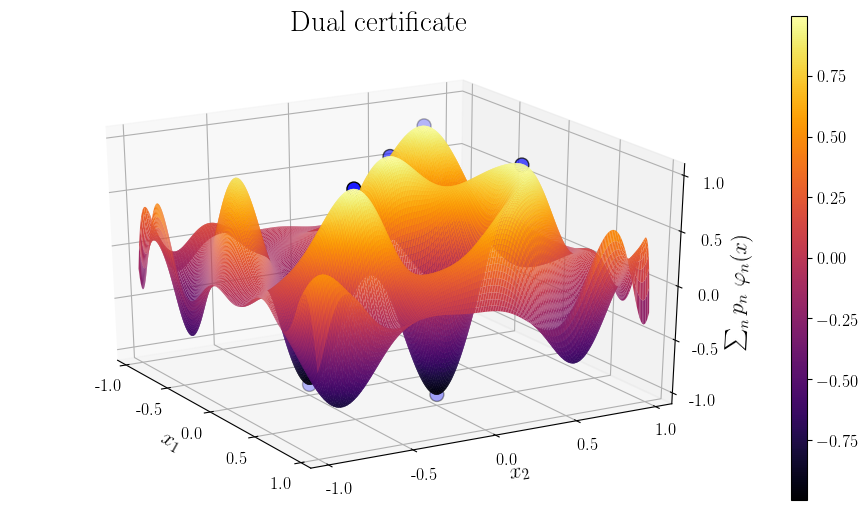

In [13]:
x_tab, y_tab = -1:0.01:1, -1:0.01:1
z_tab = Surface((abs,ord) -> dualcertif([abs, ord]), x_tab, y_tab)

surface(x_tab, y_tab, z_tab, linealpha = 0.3, camera=(60,25), show=true)
plot!(xlabel=L"$x_1$", ylabel=L"$x_2$", 
      zlabel=L"$\sum_n p_n~\varphi_n(x)$",
      title="Dual certificate")

scatter!([atom.center[1] for atom in μ.atoms], [atom.center[2] for atom in μ.atoms],
         [sign(atom.weight) for atom in μ.atoms], markersize = 10, markeralpha = 0.9, 
         markercolor = :blue, legend=false)

plot!(size=(850, 500), right_margin=10mm);

The figure above shows the dual certificate $\sum_n p_n~\varphi_n(x)$

## Noisy setting

### 1D example

In [14]:
σ = 1e-4
λ = σ;

In [15]:
locations = [[-3/4], [1/2], [1/8]]
amplitudes = [1 1 -1]

@polyvar x[1:1]
domain = @set - (x[1] + 1) * (x[1] + 1/2) * x[1] * (x[1] - 1) >= 0

d = 15
ϵ = 1e-3;

In [16]:
objvalue, μ, dualcertif = example(x, locations, amplitudes, domain, d, ϵ, σ, λ);

In [17]:
println("Objective value : ", objvalue)

Objective value : 2.7617559490442645


In [18]:
println("Optimal measure : ")
show(μ)

Optimal measure : 
Atomic measure on the variables x[1] with 7 atoms:
 at [-0.75711] with weight 0.8701191988165453
 at [-0.670254] with weight 0.15174408255213068
 at [0.999998] with weight 0.003261793826434831
 at [0.549837] with weight 0.809920177007429
 at [-0.999955] with weight -0.0001889114941474255
 at [0.86332] with weight -0.022765825257295223
 at [0.053558] with weight -0.8119945707950517

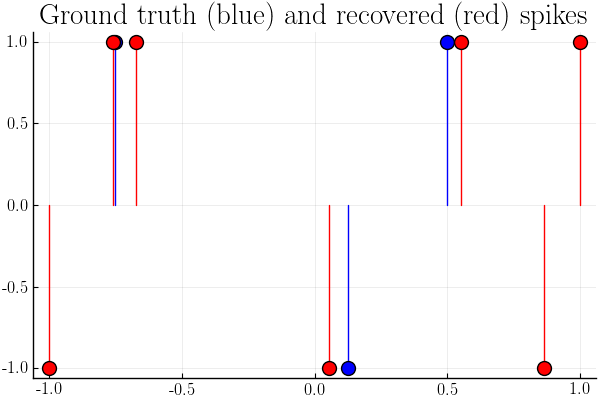

In [19]:
Plots.plot(locations, amplitudes, line=:stem, marker=:circle, markersize=10, 
           color="blue", legend=false)

plot!([atom.center[1] for atom in μ.atoms], [sign(atom.weight) for atom in μ.atoms], 
      line=:stem, marker=:circle, markersize=10, color="red")

plot!(title="Ground truth (blue) and recovered (red) spikes")